# ***NUTRIWISE.io***
#### *Trouve les meilleurs ingrédients pour le plat que tu veux manger !*
***
## Problématique
Après une réflexion intense, j'ai enfin choisi ! Ce soir, ce sera spaghetti à la bolognaise.\
Arrivé devant le rayon : difficile ! Un éventail large de pâtes et sauces...\
Mais quels ingrédients sont les meilleurs pour ma santé ? L'environnement ?\
Je n'ai pas envie de scanner chaque code-barre, il me faut quelque chose qui me dise instantanément quoi prendre !\
La solution : **NUTRIWISE.io**

## Données
### Source
Nous utiliserons ici le jeu de données `fr.openfoodfacts.org.products.csv` fourni par OpenFoodFacts.

### Variables utilisées

Après exploration des données ***NUTRIWISE.io*** va utiliser les données suivantes :`['code',  'product_name', 'main_category_fr', 'countries_tags', 'manufacturing_places_tags', 'nutriscore_score', 'nutriscore_grade', 'ecoscore_score','ecoscore_grade','carbon-footprint_100g', 'additives_n', 'sugars_100g', 'fat_100g', 'saturated-fat_100g', 'sodium_100g']`

Le but va être de créer un score mêlant le nutriscore et l'ecoscore pour trouver l'ingrédient optimal.
Lorsque le nutriscore est indisponible, nous allons essayer de le déterminer grâce aux teneurs en sucre, gras, gras saturé et sel.
Lorsque l'ecoscore est indisponible, nous allons essayer de le déterminer grâce à l'empreinte carbone.


## Lecture des données

In [1]:
# Imports
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [2]:
# Reading of the CSV file and creation of the DataFrame
nrows=500000 # This value for the tests to improve the running time
cols = ['code',  'product_name', 'main_category_fr', 'categories_fr', 'categories_tags', 'countries_tags', 'manufacturing_places_tags', \
        'nutriscore_score', 'nutriscore_grade', 'ecoscore_score','ecoscore_grade', \
        'additives_n','carbon-footprint_100g', 'sugars_100g', 'fat_100g', 'saturated-fat_100g', 'sodium_100g']

start_time = time.time()
# This line to run the reading on a nrows sample
# df= pd.read_csv('fr.openfoodfacts.org.products.csv', sep='\t', usecols=cols, low_memory=True, nrows=nrows)

#This line to run the reading on the entire CSV file
df= pd.read_csv('fr.openfoodfacts.org.products.csv', sep='\t', usecols=cols, low_memory=True)

end_time = time.time()
print(f"Running time to read csv : {end_time - start_time:.2f} seconds")

total_df_length = len(df)
formatted_total_df_length = format(total_df_length, ',').replace(',', ' ')

/tmp/ipykernel_33679/4144064526.py:12: DtypeWarning: Columns (0,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df= pd.read_csv('fr.openfoodfacts.org.products.csv', sep='\t', usecols=cols, low_memory=True)


Running time to read csv : 44.75 seconds


## Nettoyage des données
### Démarche
#### Contrainte géographique

Dans un premier temps, nous allons nous concentrer sur la France. Notre première étape sera donc de garder les ingrédients seulement vendus en France.
Ensuite, nous enlèverons les doublons de cette base.

6 lignes étaient des doublons parfaits.
Au total, il y avait 2 829 821 lignes dans la base initiale. 
Après avoir gardé seulement les produits vendus en France, il y a 970 916, soit 34.31 % de la base initiale.


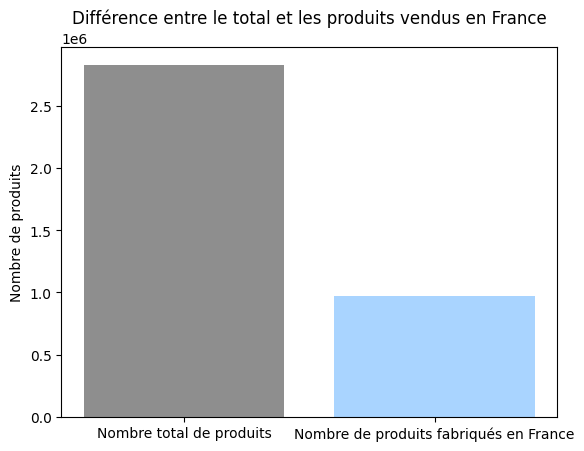

In [3]:
# Drop rows with the selling countries are not known
df = df.dropna(subset=['countries_tags'])


# Filter the rows with only countries_tags that contains 'france'
france_df = df[df['countries_tags'].str.contains('france')]
france_df = france_df[cols]
france_df_length = len(france_df)
formatted_france_df_length = format(france_df_length, ',').replace(',', ' ')
france_df = france_df.drop_duplicates()
france_df_uniques_length = len(france_df)
france_df_backup = france_df
print(f"{france_df_length - france_df_uniques_length} lignes étaient des doublons parfaits.")
print(f"Au total, il y avait {formatted_total_df_length} lignes dans la base initiale. \nAprès avoir gardé seulement les produits vendus en France, il y a {formatted_france_df_length}, soit {round(france_df_length/total_df_length* 100,2)} % de la base initiale.")

# GRAPH
values = [total_df_length, france_df_length]
labels = ["Nombre total de produits", "Nombre de produits fabriqués en France"]
fig, ax = plt.subplots()
ax.bar(labels, values, color=['#8E8E8E', '#A9D4FF'])
ax.set_ylabel('Nombre de produits')
ax.set_title('Différence entre le total et les produits vendus en France')

plt.show()

#### Erreurs lexicales

In [4]:
# check if there are two different data types in each column
for col in france_df.columns:
    if france_df[col].nunique() > 1:
        print(f"{col} : {france_df[col].dtypes}")
        
print("\nOn peut voir qu'il n'y a rien de particulier ici. Ceux qui doivent être des nombres sont des nombres, ceux qui doivent être du texte sont du texte.")

code : object
product_name : object
main_category_fr : object
categories_fr : object
categories_tags : object
countries_tags : object
manufacturing_places_tags : object
nutriscore_score : float64
nutriscore_grade : object
ecoscore_score : float64
ecoscore_grade : object
additives_n : float64
carbon-footprint_100g : float64
sugars_100g : float64
fat_100g : float64
saturated-fat_100g : float64
sodium_100g : float64

On peut voir qu'il n'y a rien de particulier ici. Ceux qui doivent être des nombres sont des nombres, ceux qui doivent être du texte sont du texte.


#### Gestion des valeurs nulles
##### Basiques

In [5]:
filled_pct = france_df.count() / len(france_df) * 100
print(filled_pct)

# Remove the lines which do not have product_name
france_df = france_df.dropna(subset=['product_name'])
france_df = france_df.drop(columns=['main_category_fr', 'categories_tags', 'carbon-footprint_100g'])

code                         100.000000
product_name                  97.261126
main_category_fr              49.220216
categories_fr                 49.220216
categories_tags               49.220216
countries_tags               100.000000
manufacturing_places_tags      8.744065
nutriscore_score              37.378748
nutriscore_grade              37.378748
ecoscore_score                35.318825
ecoscore_grade                99.905965
additives_n                   29.280572
carbon-footprint_100g          0.032959
sugars_100g                   76.869844
fat_100g                      76.418000
saturated-fat_100g            76.909600
sodium_100g                   72.523509
dtype: float64


On peut voir qu'il y a des produits qui n'ont pas de nom. Nous n'avons pas vraiment d'autre choix que de les supprimer. \
Les différentes colonnes de catégories ont exactement le même taux de remplissage. Nous choisissons donc de garder les catégories en Français. \
La colonne de carbon-footprint_100g a un très faible taux de remplissage. Pour le moment, nous choisissons de la retirer.
**Les lignes de code correspondants sont dans la cellule au-dessus à la suite du calcul de remplissage.**

#### Variables qualitatives

Dans notre cas, nous allons avoir essentiellement besoin du **Nutriscore** et de l'**Eco-score**. \
Si ces deux valeurs ne sont pas présentes, nous allons essayer de les déduire grâce aux informations nutritionnelles et écologiques présentes pour le produit.
Nous allons donc éliminer les valeurs où tous les champs : `['nutriscore_score', 'nutriscore_grade', 'ecoscore_score','ecoscore_grade','carbon-footprint_100g', 'additives_n', 'sugars_100g', 'fat_100g', 'saturated-fat_100g', 'sodium_100g']` sont nuls. \
Si une valeur est présente, nous gardons la ligne pour le moment pour essayer de la déduire. 

En lançant une fois la fonction dropna, nous vyons que l'ecoscore grade est à unknown est pas forcément à nul.
Je vais donc voir quelles sont les valeurs des ecoscore_grade et nutriscore_grade

In [10]:
def remove_quant_var_null_values():
    without_all_characteristics_nan_df = france_df.dropna(subset=['additives_n', 'sugars_100g', 'fat_100g', 'saturated-fat_100g', 'sodium_100g'], thresh=1)
    without_all_characteristics_nan_df_length = len(without_all_characteristics_nan_df)
    formatted_without_all_characteristics_nan_df_length = format(without_all_characteristics_nan_df_length, ',').replace(',', ' ')
    print(f"Il y avait {formatted_france_df_length} produits, après ce nettoyage il y en a : {formatted_without_all_characteristics_nan_df_length}.")
    return without_all_characteristics_nan_df

In [11]:
cols = ['nutriscore_grade', 'ecoscore_grade']
for col in cols:
    print(f"{col} : {france_df[col].unique()}")

nutriscore_grade : [nan 'a' 'd' 'b' 'c' 'e']
ecoscore_grade : [nan 'd' 'c' 'b' 'e' 'a']


Pour le nutriscore, pas de problème.\
Pour l'eco-score, nous avons deux valeurs qui ne sont pas utilisables : unknown et and not-applicable. Nous les remplacerons par nan. \
Nous relançons ensuite la même fonction que précédement.

In [12]:
france_df['ecoscore_grade'] = france_df['ecoscore_grade'].replace(['unknown', 'not-applicable'], np.nan)
france_df_without_all_null_quant_var = remove_quant_var_null_values()
cols = ['nutriscore_grade', 'ecoscore_grade']
for col in cols:
    print(f"{col} : {france_df_without_all_null_quant_var[col].unique()}")


Il y avait 970 916 produits, après ce nettoyage il y en a : 783 429.
nutriscore_grade : ['a' nan 'd' 'b' 'c' 'e']
ecoscore_grade : ['d' nan 'c' 'b' 'e' 'a']


Ces deux colonnes sont maintenant uniformes.
#### Variables quantitatives
Attaquons nous maintenant aux variables quantitatives. Il s'agit des colonnes `['sugars_100g', 'fat_100g', 'saturated-fat_100g', 'sodium_100g', 'carbon-footprint_100g']`. \
Toutes ces variables sont sensées être des proportions sur 100g. Elles ne doivent donc être ni négatives, ni supérieures à 100. Voyons voir la répartition.

In [17]:
# define the bins
bins = [-float('inf'), -1e-15, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, float('inf')]

for col in ['sugars_100g', 'fat_100g', 'saturated-fat_100g', 'sodium_100g']:
    cut_series = pd.cut(france_df_without_all_null_quant_var[col], bins)
    value_counts = cut_series.value_counts(sort=False)
    print(f"Value counts for column '{col}':\n{value_counts}\n")

Value counts for column 'sugars_100g':
sugars_100g
(-inf, -1e-15]         1
(-1e-15, 10.0]    490357
(10.0, 20.0]       72912
(20.0, 30.0]       52322
(30.0, 40.0]       35931
(40.0, 50.0]       29350
(50.0, 60.0]       31399
(60.0, 70.0]       13895
(70.0, 80.0]        9400
(80.0, 90.0]        4357
(90.0, 100.0]       3447
(100.0, inf]          19
Name: count, dtype: int64

Value counts for column 'fat_100g':
fat_100g
(-inf, -1e-15]         1
(-1e-15, 10.0]    408072
(10.0, 20.0]      124743
(20.0, 30.0]      101141
(30.0, 40.0]       57204
(40.0, 50.0]       19394
(50.0, 60.0]       10417
(60.0, 70.0]        3842
(70.0, 80.0]        2649
(80.0, 90.0]        1852
(90.0, 100.0]       9651
(100.0, inf]          29
Name: count, dtype: int64

Value counts for column 'saturated-fat_100g':
saturated-fat_100g
(-inf, -1e-15]         0
(-1e-15, 10.0]    598015
(10.0, 20.0]      108156
(20.0, 30.0]       31015
(30.0, 40.0]        2742
(40.0, 50.0]         677
(50.0, 60.0]        2133
(60.0, 70.

En voyant ça, nous allons enlever les valeurs négatives et > 100 à pour ces trois colonnes.

In [31]:
cols = ['sugars_100g', 'fat_100g', 'saturated-fat_100g', 'sodium_100g']
mask = (france_df_without_all_null_quant_var[cols] >= 0) & (france_df_without_all_null_quant_var[cols] <= 100)
france_df_filtered = france_df_without_all_null_quant_var[mask.all(axis=1)]
france_df_without_all_null_quant_var_length = format(len(france_df_without_all_null_quant_var), ',').replace(',', ' ')
france_df_filtered_length = format(len(france_df_filtered), ',').replace(',', ' ')
print(f"Il y avait {france_df_without_all_null_quant_var_length} produits dans la liste, il y en a maintenant : {france_df_filtered_length}")

Il y avait 783 429 produits dans la liste, il y en a maintenant : 686 936


#### Remplissage des données manquantes
##### Cas du nutri-score
Sur les conseils de mon mentor, je vais tenter d'utiliser la méthode du K-Nearest Neighbour (KNN)

In [33]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score



ModuleNotFoundError: No module named 'sklearn'